In [1]:
import acquire
import prepare
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import pearsonr, spearmanr, stats
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import RFE
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor

import warnings
warnings.filterwarnings("ignore")

# Zillow - Predicting Tax Assessed Value

#### Matthew Luna, March 30, 2022

# Executive Summary

## Project Goals
#### - Build a model that predicts the property tax assessed values of single family properties in 2017

## Project Description
#### - Improve Zillow's model that predicts home values to provide valuable information to users in the market
#### - All models will be compared and evaluated by how well it performs over the baseline

# Acquisition and Preparation

In [2]:
df = acquire.get_zillow_data()
df.shape

Using cached csv


(52441, 7)

#### Prepare process:
- After acquiring data from the mySQL through acquire.py
- Became familiar with data 
    - ( # of observations & features, column names, data types, null values, df.describe , and value counts)
-**Created functions that do the following:**
- Remove nulls and outliers
- Rename columns and change data types where necessary
- Create a 'age' column based on year built
- Convert 'fips' values to los angeles, orange, and ventura
- Create a 'state' column with 'california' values
- Create dummy variables for columns with object data type
- Visualize data and observe distributions
- Clean data, split data, and scale the data

In [3]:
train, validate, test, train_scaled, validate_scaled, test_scaled = prepare.wrangle_zillow()
train.shape, validate.shape, test.shape, train_scaled.shape, validate_scaled.shape, test_scaled.shape

Using cached csv


((26239, 12), (11246, 12), (9372, 12), (26239, 12), (11246, 12), (9372, 12))

# Data Context

- The original dataset was made up of 52,441 rows and 7 columns
- tax values ranged from 1,000 to 49,061,236
- Mean tax value is 529,688
- bedroom/bathroom columns had min numbers == 0 and max numbers like 14/18 
- After the preparation process:
    - Cleaned data is made up of 46,857 rows and 12 columns
        - ***MAX*** tax value 1,751,776
        - ***MEAN*** tax value 416,710
- **93% of the original dataset remains to be explored**


# Exploration 

In [4]:
# Heatmap for multivariate analysis
# Checking if columns and tax_value are related

df_corr = train.corr().reset_index()
corr_matrix = train.corr().sort_values(by = 'tax_value', ascending=False)
corr_matrix["tax_value"].reset_index().style.background_gradient('gist_earth', vmin = -1, vmax = 1)

,index,tax_value
0,tax_value,1.000000
1,square_ft,0.531314
2,bathroom,0.431084
3,bedroom,0.246607
4,year_built,0.237724
5,orange,0.170452
6,lot_size,0.129537
7,ventura,0.025680
8,los_angeles,-0.173619
9,age,-0.237724


## Question 1:
    - Does square ft affect tax value?

### Hypothesis testing with Pearson's Correlation Coefficient

   Null Hypothesis : There is no linear relationship between square_ft and property tax value

   ***Alternative Hypothesis:*** There is a linear relationship between square_ft and tax value

We reject the null hypothesis
p-value: 0.0
---------------------------------------------


<Figure size 720x576 with 0 Axes>

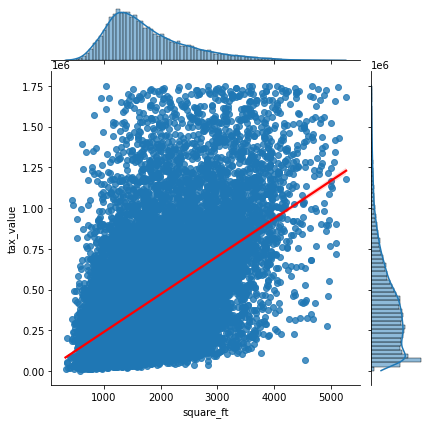

In [5]:
# Pearsonsr statistical analysis

alpha = .05
r, p_value = stats.pearsonr(train.square_ft, train.tax_value)
r, p_value

if p_value > alpha:
    print('We fail to reject the null hypothesis')    
else:
    print('We reject the null hypothesis')
print(f'p-value: {round(p_value,3)}')
print('---' * 15)

# Visualize square_ft and it's relationship with tax_value
plt.figure(figsize=(10,8))
sns.jointplot(x= 'square_ft',y= 'tax_value', data=train, kind = 'reg', line_kws = {'color' :'red'})
plt.show()


## Question 2:
    - Does lot_size affect tax value?

### Hypothesis testing with Pearson's Correlation Coefficient

   Null Hypothesis : There is no linear relationship between number of bathrooms and property tax value

   ***Alternative Hypothesis:*** There is a linear relationship between number of bathrooms and tax value

We reject the null hypothesis
p-value: 0.0
---------------------------------------------


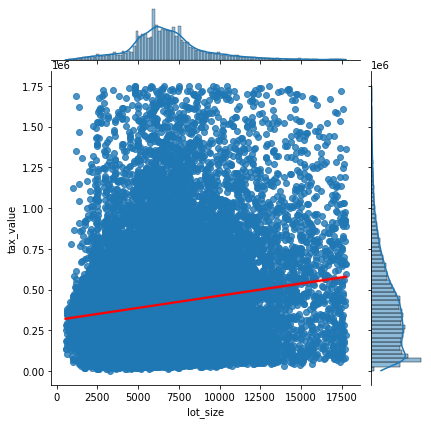

In [6]:
# Pearsonsr statistical analysis
alpha = .05
r, p_value = stats.pearsonr(train.square_ft, train.tax_value)
r, p_value

if p_value > alpha:
    print('We fail to reject the null hypothesis')
else:
    print('We reject the null hypothesis')
print(f'p-value: {round(p_value,3)}')
print('---' * 15)

# visualize lot_size and tax_value
sns.jointplot('lot_size', 'tax_value', data=train, kind = 'reg', line_kws={'color':'red'})
plt.show()

## Question 3:
    - Does bedroom count affect tax value?

### Hypothesis testing with Pearson's Correlation Coefficient

   Null Hypothesis : There is no linear relationship between number of bedrooms and property tax value

   ***Alternative Hypothesis:*** There is a linear relationship between number of bedrooms and tax value

We reject the null hypothesis
p-value: 0.0
---------------------------------------------


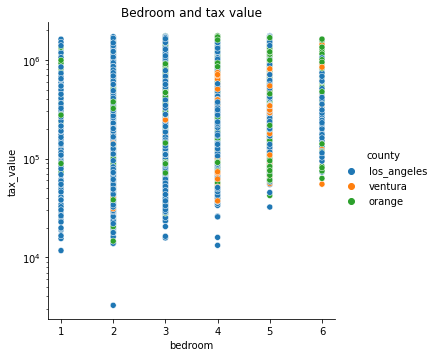

In [7]:
# Pearsonsr statistical analysis
alpha = 0.05
r, p_value = pearsonr(train.bedroom, train.tax_value)
r, p_value

if p_value > alpha:
    print('We fail to reject the null hypothesis')
else:
    print('We reject the null hypothesis')
print(f'p-value: {round(p_value,3)}')
print('---' * 15)

ax = sns.relplot(x='bedroom', y='tax_value', data=train, kind='scatter', hue='county')
ax.set(yscale='log')
plt.title('Bedroom and tax value')
plt.show()

## Question 4
        - Does bathroom count affect tax_value?

### Hypothesis testing with Pearson's Correlation Coefficient

   Null Hypothesis : There is no linear relationship between number of bathrooms and property tax value

   ***Alternative Hypothesis:*** There is a linear relationship between number of bathrooms and tax value

We reject the null hypothesis
p-value: 0.0
---------------------------------------------


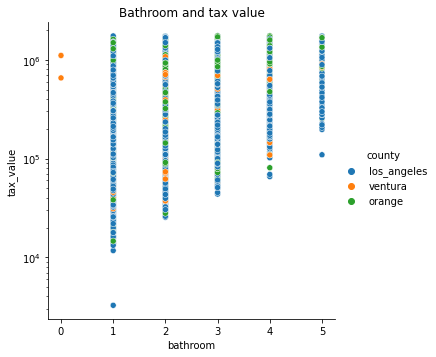

In [21]:
alpha = 0.05

r, p_value = pearsonr(train.bathroom, train.tax_value)
r, p_value

if p_value > alpha:
    print('We fail to reject the null hypothesis')
else:
    print('We reject the null hypothesis')
print(f'p-value: {round(p_value,3)}')
print('---' * 15)

#visualize bathroom and tax value

ax2 = sns.relplot(x='bathroom', y='tax_value', data=train, kind='scatter', hue='county')
ax2.set(yscale='log')
plt.title('Bathroom and tax value')
plt.show()

## Statistical analysis using Pearson's Correlation Coefficient 
#### - Supports a linear relationship between square_ft, bathrooms, bedrooms, lot size and the property tax value

## Exploration Summary
- **There are linear relationships between bedroom, bathroom, lot_size, square_ft, and tax_value assessment**
- **Square_ft has the strongest correlation out of the features**
- **The listed features will be used to fit the model and evaluate performance**

# Modeling
- Recursive Feature Elimination, RFE, used for feature selection
    - hyperparameters set to 4
- 4 types of model were created and best performing are shown
    - Linear Regression OLS
    - LassoLars w/ alpha = 1.0
    - 3rd degree Polynomial Regression
- The Polynomial Regression model performed  best
    - Test data was evaluated
    
- Data is split into X, y, and X_scaled datasets
    - isolating features, the target, and scaled data

In [9]:
X_train, y_train, X_validate, y_validate, X_test, y_test = prepare.create_x_y(train, validate, test, train_scaled, validate_scaled, test_scaled)

In [10]:
# initialize the ML algorithm
lm = LinearRegression()

# create the rfe object, indicating the ML object (lm) and the number of features I want to end up with. 
rfe = RFE(lm, n_features_to_select=4)

# fit the data using RFE
rfe.fit(X_train , y_train)  

feature_mask = rfe.support_

rfe_feature = X_train.iloc[:, feature_mask].columns.tolist()

rfe_feature

['bedroom', 'bathroom', 'square_ft', 'lot_size']

##     **- Baseline**
### - RMSE using Mean Baseline performed better than Median Baseline.
#### - Model RMSE must perform better than Mean baseline RMSE of $ 316,189.34

In [11]:
# We need y_train and y_validate to be dataframes to append the new columns with predicted values. 
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

# 1. Predict tax value_pred_mean
tax_value_pred_mean = y_train['tax_value'].mean()
y_train['tax_value_pred_mean'] = tax_value_pred_mean
y_validate['tax_value_pred_mean'] = tax_value_pred_mean

# 2. compute tax value_pred_median
tax_value_pred_median = y_train['tax_value'].median()
y_train['tax_value_pred_median'] = tax_value_pred_median
y_validate['tax_value_pred_median'] = tax_value_pred_median

# 3. RMSE of tax_value_pred_mean
mean_rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_mean)**(1/2)
mean_rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_mean)**(1/2)

print("Baseline RMSE using Mean\nTrain/In-Sample: ", round(mean_rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(mean_rmse_validate, 2))

# 4. RMSE of tax_value_pred_median
median_rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_median)**(1/2)
median_rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_median)**(1/2)

print("\nBaseline RMSE using Median\nTrain/In-Sample: ", round(median_rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(median_rmse_validate, 2))

Baseline RMSE using Mean
Train/In-Sample:  316189.34 
Validate/Out-of-Sample:  310611.92

Baseline RMSE using Median
Train/In-Sample:  322894.86 
Validate/Out-of-Sample:  316684.9


## LinearRegression (OLS)

- Ordinay Least Squares Linear Regression Model

In [12]:
# create the Linear Regression model object
lm = LinearRegression(normalize=True)

# fit the model to training data and specify column in y_train  
lm.fit(X_train[['bedroom', 'bathroom', 'square_ft', 'lot_size']], y_train.tax_value)

# predict train & validate
y_train['tax_value_pred_lm'] = lm.predict(X_train[['bedroom', 'bathroom', 'square_ft', 'lot_size']])
y_validate['tax_value_pred_lm'] = lm.predict(X_validate[['bedroom', 'bathroom', 'square_ft', 'lot_size']])

# evaluate rmse for train & validate
lm_rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_lm)**(1/2)
lm_rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_lm)**(1/2)

print("RMSE for OLS using LinearRegression\n\nTraining/In-Sample: ", lm_rmse_train, 
      "\nValidation/Out-of-Sample: ", lm_rmse_validate)

RMSE for OLS using LinearRegression

Training/In-Sample:  264042.65217969974 
Validation/Out-of-Sample:  259552.16822354202


## LassoLars

- LassoLars model with alpha = 1.0

In [13]:
# create the model object
lars = LassoLars(alpha=1.0)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lars.fit(X_train[['bedroom', 'bathroom', 'square_ft', 'lot_size']], y_train.tax_value)

# predict train
y_train['tax_value_pred_lars'] = lars.predict(X_train[['bedroom', 'bathroom', 'square_ft', 'lot_size']])

# evaluate: rmse
ll_rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_lars)**(1/2)

# predict validate
y_validate['tax_value_pred_lars'] = lars.predict(X_validate[['bedroom', 'bathroom', 'square_ft', 'lot_size']])

# evaluate: rmse
ll_rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_lars)**(1/2)

print("RMSE for Lasso + Lars\n\nTraining/In-Sample: ", ll_rmse_train, 
      "\nValidation/Out-of-Sample: ", ll_rmse_validate)

RMSE for Lasso + Lars

Training/In-Sample:  264043.05475756276 
Validation/Out-of-Sample:  259555.23381744855


## TweedieRegressor (GLM)
- Generalized Linear model with power = 1.0

In [14]:
# create the model object
glm = TweedieRegressor(power=1.0, alpha=0)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
glm.fit(X_train[['bedroom', 'bathroom', 'square_ft', 'lot_size']], y_train.tax_value)

# predict train
y_train['tax_value_pred_glm'] = glm.predict(X_train[['bedroom', 'bathroom', 'square_ft', 'lot_size']])

# evaluate: rmse
glm_rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_glm)**(1/2)

# predict validate
y_validate['tax_value_pred_glm'] = glm.predict(X_validate[['bedroom', 'bathroom', 'square_ft', 'lot_size']])

# evaluate: rmse
glm_rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_glm)**(1/2)

print("RMSE for GLM using Tweedie, power=1 & alpha=0\n\nTraining/In-Sample: ", glm_rmse_train, 
      "\nValidation/Out-of-Sample: ", glm_rmse_validate)

RMSE for GLM using Tweedie, power=1 & alpha=0

Training/In-Sample:  265254.999025759 
Validation/Out-of-Sample:  262148.21897893376


## PolynomialRegression
- Polynomial Features are created and fit to model.
    - hyperparameter 'degree = 3' performed best

In [15]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=3)

# fit and transform X_train_scaled
X_train_degree3 = pf.fit_transform(X_train[['bedroom', 'bathroom', 'square_ft', 'lot_size']])

# transform X_validate_scaled & X_test_scaled
X_validate_degree3 = pf.transform(X_validate[['bedroom', 'bathroom', 'square_ft', 'lot_size']])
X_test_degree3 = pf.transform(X_test[['bedroom', 'bathroom', 'square_ft', 'lot_size']])

In [16]:
# create the model object
lm2 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm2.fit(X_train_degree3, y_train.tax_value)

# predict train
y_train['tax_value_pred_lm2'] = lm2.predict(X_train_degree3)

# evaluate: rmse
pf_rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_lm2)**(1/2)

# predict validate
y_validate['tax_value_pred_lm2'] = lm2.predict(X_validate_degree3)

# evaluate: rmse
pf_rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_lm2)**(1/2)

print("RMSE for Polynomial Model, degrees=3\n\nTraining/In-Sample: ", pf_rmse_train, 
      "\nValidation/Out-of-Sample: ", pf_rmse_validate)

RMSE for Polynomial Model, degrees=3

Training/In-Sample:  261089.62591559946 
Validation/Out-of-Sample:  258209.98678164158


In [17]:
metric_df = pd.DataFrame(data = [{'Model': 'Baseline', 'Train Baseline': mean_rmse_train, 'Validate Baseline':mean_rmse_validate, 
                          }])
metric_df = metric_df.append({'Model': 'Linear Regression', 'Train Baseline': lm_rmse_train , 'Validate Baseline':lm_rmse_validate, 
                          }, ignore_index = True)
metric_df = metric_df.append({'Model': 'LassoLars', 'Train Baseline': ll_rmse_train , 'Validate Baseline':ll_rmse_validate, 
                          }, ignore_index = True)
metric_df = metric_df.append({'Model': 'TweedieRegressor (GLM)', 'Train Baseline': glm_rmse_train , 'Validate Baseline':glm_rmse_validate, 
                          }, ignore_index = True)
metric_df = metric_df.append({'Model': '3rd degree Polynomial Regression', 'Train Baseline': pf_rmse_train , 'Validate Baseline':pf_rmse_validate, 
                          }, ignore_index = True)
metric_df

,Model,Train Baseline,Validate Baseline
0,Baseline,316189.343454,310611.924741
1,Linear Regression,264042.652180,259552.168224
2,LassoLars,264043.054758,259555.233817
3,TweedieRegressor (GLM),265254.999026,262148.218979
4,3rd degree Polynomial Regression,261089.625916,258209.986782


In [18]:
y_test = pd.DataFrame(y_test)

# Fit the data
lm2.fit(X_test_degree3, y_test.tax_value)

# predict on test
y_test['tax_value_pred_lm2'] = lm2.predict(X_test_degree3)
                                
# evaluate: rmse
pf_rmse_test = mean_squared_error(y_test.tax_value, y_test.tax_value_pred_lm2)**(1/2)

# add residual column to highlight difference
y_test['lm2_resid'] = y_test.tax_value - y_test.tax_value_pred_lm2

print("RMSE for Test Model using 3rd Degree Polynomial Regression\n\nTest Performance: ", pf_rmse_test)

RMSE for Test Model using 3rd Degree Polynomial Regression

Test Performance:  260182.51852453384


In [19]:
results_df = pd.DataFrame(data = [{'Model': 'PolynomialFeatures', 'RMSE Baseline': mean_rmse_train, 'Test RMSE':pf_rmse_test, 'Performance': (mean_rmse_train - pf_rmse_test)
                          }])
results_df

,Model,RMSE Baseline,Test RMSE,Performance
0,PolynomialFeatures,316189.343454,260182.518525,56006.824929


# CONCLUSION
## Summary
Project goals were:
- Develop a ML algorithm that predicts property tax assessed value for single family homes in 2017
- Identified drivers of tax value:
    - Home square footage
    - Number of bedrooms
    - Number of bathrooms
    - Lot size
 

## RECOMMENDATONS
- I recommend the 3rd degree Polynomial Regression model 
    - Test data predicted an RMSE of 260,182.52 which is ***56,006.82*** more accurate than the baseline   
    

# NEXT STEPS
##### - With more time I would like to include more columns, improve my feature engineering, and increase model performance